## Simple Lyot Coronagraph
Optics without the apodizer. Sanity check

In [1]:
%%capture
## ignore warnings...

## autoreload scripts
%load_ext autoreload
%autoreload 2

from __future__ import division
exec(open('../prep.py'))
exec(open('../codes/func.py'))
exec(open('../codes/util.py'))
% matplotlib inline

### Incident light

### Masks
#### read in...

In [2]:
primary_path  = '../../masks/gemini_primary.fits'

## K band - 2.19 um ; use K1
#apod_k_path = '../../masks/gpi_k1_apodizer.fits'
lyot_k_path = '../../masks/gpi_k1_lyot.fits'
fpm_k_path = '../../masks/gpi_k1_fpm.fits'

In [19]:
pri_d_, pri_h  = read_fits(primary_path)

#apo_k_d, apo_k_h  = read_fits(apod_k_path)
fpm_k_d_, fpm_k_h  = read_fits(fpm_k_path)
lyo_k_d_, lyo_k_h  = read_fits(lyot_k_path)

K band (k1)

In [23]:
pri_d = pri_d_[::2,::2]
fpm_k_d = fpm_k_d_[::2,::2]
lyo_k_d = lyo_k_d_[::2,::2]

pNaxis, fNaxis, lNaxis = pri_h['NAXIS1']/2, fpm_k_h['NAXIS1']/2, lyo_k_h['NAXIS1']/2
p_pixs, f_pixs, l_pixs = pri_h['pixscale']*2, fpm_k_h['pixscale']*2, lyo_k_h['pixscale']*2

Apodizer    size = 512.0 pixels; pixel scale = 0.015625
Coronagraph size = 512.0 pixels; pixel scale = 0.0052734375
Lyot mask   size = 512.0 pixels; pixel scale = 0.015625


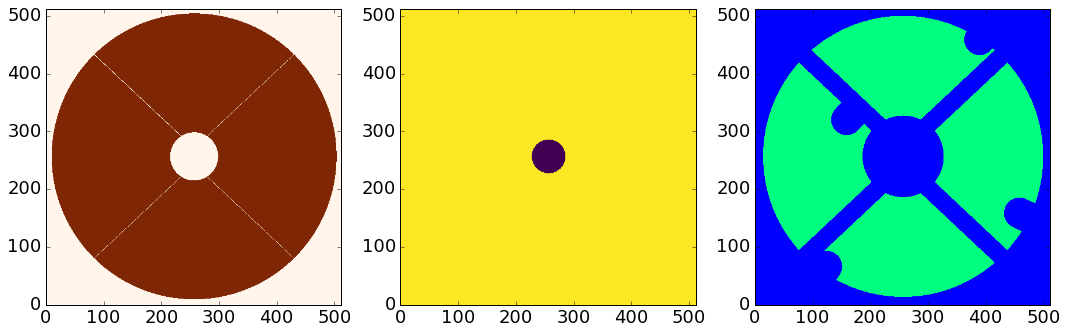

In [24]:
plt.figure(figsize=(18,36))
plt.subplot(131); plt.imshow(pri_d,origin='lower',cmap=plt.get_cmap('Oranges'))
plt.subplot(132); plt.imshow(fpm_k_d,origin='lower',cmap=plt.get_cmap('viridis'))
plt.subplot(133); plt.imshow(lyo_k_d,origin='lower',cmap=plt.get_cmap('winter'))
print 'Apodizer    size = %s pixels; pixel scale = %s' %(pNaxis,p_pixs)
print 'Coronagraph size = %s pixels; pixel scale = %s' %(fNaxis,f_pixs)
print 'Lyot mask   size = %s pixels; pixel scale = %s' %(lNaxis,l_pixs)

#### How big is the 'primary'?
This determines the 'sampling frequency' as defined in the `sim_opt` [notebook](https://github.com/Mipanox/GPI_stuff/blob/master/sim_opt.ipynb). Original I intended to scale the sampling frequency according to the given pixelsize in the mask files, but the required value turned out to be prohibitive (7302 for K band...). So now the masks are reduced twice in size. (I do not want to force FFT to compute in 2^n grid since matching pixel sizes would only introduce more artifacts.

In [61]:
# parameters
D_tel = 7.8 * u.m
lba_k = 2.19 * u.um

## extension of the primary mask
allowedx = np.where(pri_d==1)[0]
#Sampfreq = N_pix / (allowedx.max()-allowedx.min())

## 
#pix_scale = D_tel / N_pix * Sampfreq ## physical scale
#k_pix_arc = ((lba_k/Sampfreq/D_tel).to(u.dimensionless_unscaled)*u.rad).to(u.arcsec)
#R_tel_p = N_pix / Sampfreq / 2 ## in pixel

In [63]:
## conforms to masks
k_pix_arc = p_pixs * u.arcsec

f_s = ((lba_k/D_tel/k_pix_arc).to(u.rad**-1)).value
N_pix = int((allowedx.max()-allowedx.min()) * f_s)+1
print N_pix

1824


## Inputs

In [64]:
pri_p = pad_array(pri_d,N_pix)
#apo_k_p = pad_array(apo_k_d,N_pix)
lyo_k_p = pad_array(lyo_k_d,N_pix)

### Star light

In [65]:
One = np.ones((N_pix,N_pix))
Zer = np.zeros((N_pix,N_pix))

In [66]:
Str_amp = One * pri_p
Str_pha = Zer * pri_p * u.rad

Str_inc_ef = Str_amp*np.exp(1j*Str_pha.value)

---
## Optics

(-0.1, 1.1)

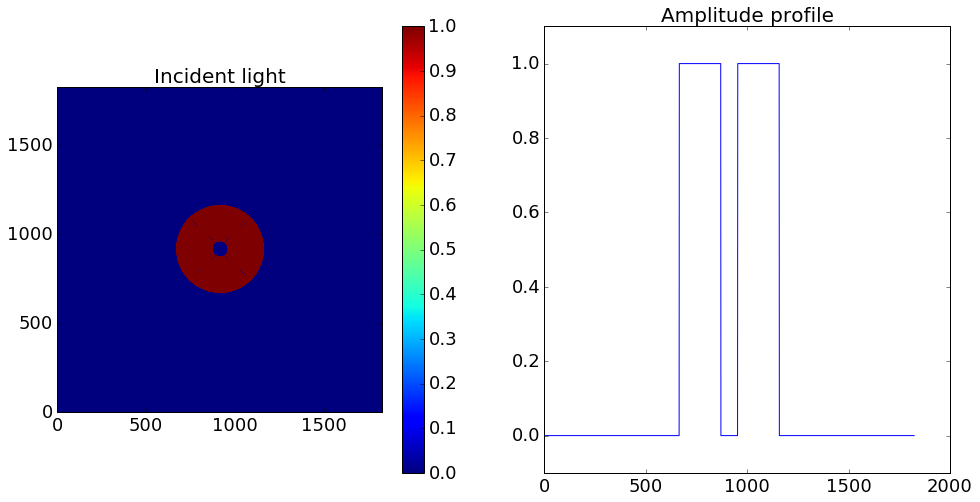

In [67]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(abs(Str_inc_ef)**2,origin='lower')
plt.title('Incident light')
plt.colorbar()

plt.subplot(122); plt.plot(abs(Str_inc_ef)[int(N_pix/2),:])
plt.title('Amplitude profile'); plt.ylim(-0.1,1.1)

### First focal plane

In [68]:
%time
Str_ffoc_ef = Ef_aft_from_Ef(Str_inc_ef)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 5.01 µs


(711, 1112)

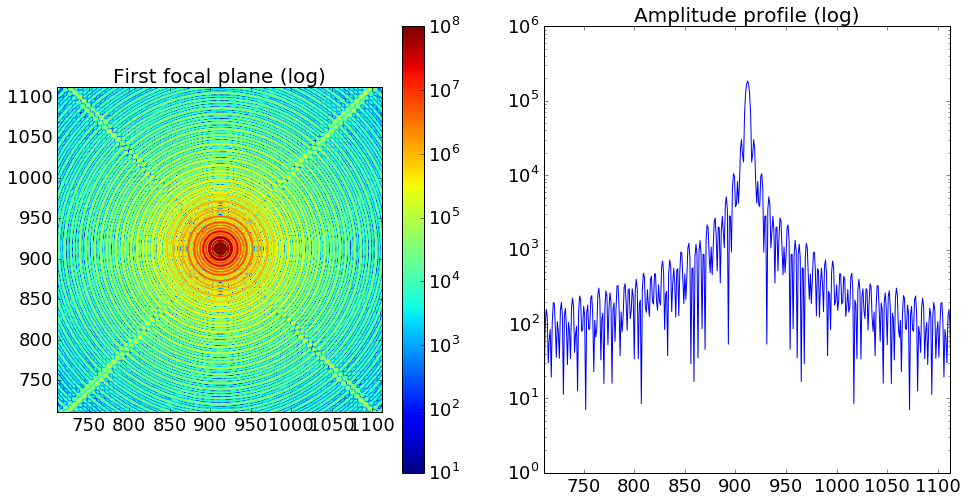

In [69]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(abs(Str_ffoc_ef)**2,origin='lower',norm=LogNorm())
plt.xlim(711,1112); plt.ylim(711,1112); plt.title('First focal plane (log)')
plt.colorbar(); plt.clim(10,1e8)

plt.subplot(122); plt.plot(abs(Str_ffoc_ef)[int(N_pix/2),:])
plt.yscale('log'); plt.title('Amplitude profile (log)')
plt.xlim(711,1112)

### Coronagraph
#### Matching the grids
Now the pixel scale for the FTed image is

In [70]:
k_pix_arc

<Quantity 0.015625 arcsec>

whereas that of the FPM is

In [71]:
fpm_k_h['pixscale']

0.00263671875

the ratio (downsampling factor) is to reduce the FPM to a size of (round off to nearest even integer)

In [72]:
down_samp_f = k_pix_arc.value / fpm_k_h['pixscale']
N_pix_down  = int(fpm_k_h['NAXIS1'] / down_samp_f) #+ 1

In [73]:
%%capture 
##
fpm_k_down = zoomArray(fpm_k_d,(N_pix_down,N_pix_down))
## try to get rid of the artifacts
fpm_k_down[np.where(fpm_k_down<0.9)]=0

## padding to N_pix x N_pix
fpm_k_p = pad_array(fpm_k_down,N_pix,pad=1)

In [74]:
## centroid
ctx,cty = (N_pix-1)/2, (N_pix-1)/2

##
kx_min,kx_max = ((0-ctx)*k_pix_arc).value,((N_pix-ctx)*k_pix_arc).value
ky_min,ky_max = ((0-cty)*k_pix_arc).value,((N_pix-cty)*k_pix_arc).value

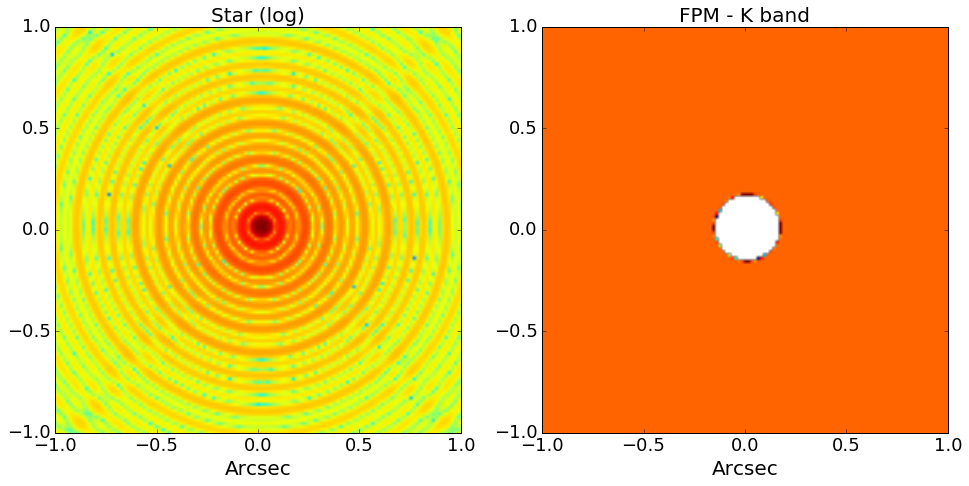

In [75]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(abs(Str_ffoc_ef)**2,origin='lower', \
                             extent=(kx_min,kx_max,ky_min,ky_max),norm=LogNorm())
plt.xlim(-1,1); plt.ylim(-1,1); plt.title('Star (log)')
plt.xlabel('Arcsec')

plt.subplot(122); plt.imshow(fpm_k_p,origin='lower', \
                             extent=(kx_min,kx_max,ky_min,ky_max),norm=LogNorm())
plt.xlim(-1,1); plt.ylim(-1,1); plt.title('FPM - K band')
plt.xlabel('Arcsec')

#### Masking

In [76]:
Str_coro_ef = Str_ffoc_ef * fpm_k_p

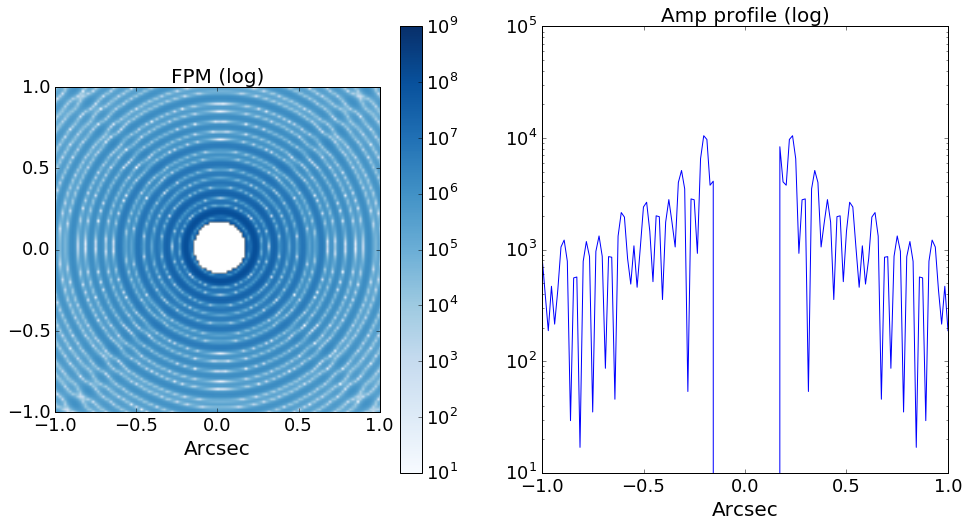

In [77]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(abs(Str_coro_ef)**2,origin='lower', \
                             extent=(kx_min,kx_max,ky_min,ky_max),norm=LogNorm(), \
                             cmap='Blues')
plt.xlim(-1,1); plt.ylim(-1,1); plt.title('FPM (log)')
plt.xlabel('Arcsec'); plt.colorbar(); plt.clim(10,1e9)

plt.subplot(122); plt.plot(np.linspace(kx_min,kx_max,N_pix),abs(Str_coro_ef)[int(N_pix/2),:])
plt.xlim(-1,1); plt.ylim(10,1e5); plt.title('Amp profile (log)')
plt.xlabel('Arcsec'); plt.yscale('log')

### Second pupil plane - Lyot
#### Transform back

In [78]:
%time
Str_2pup_ef = Ef_ift_from_Ef(Str_coro_ef)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 7.15 µs


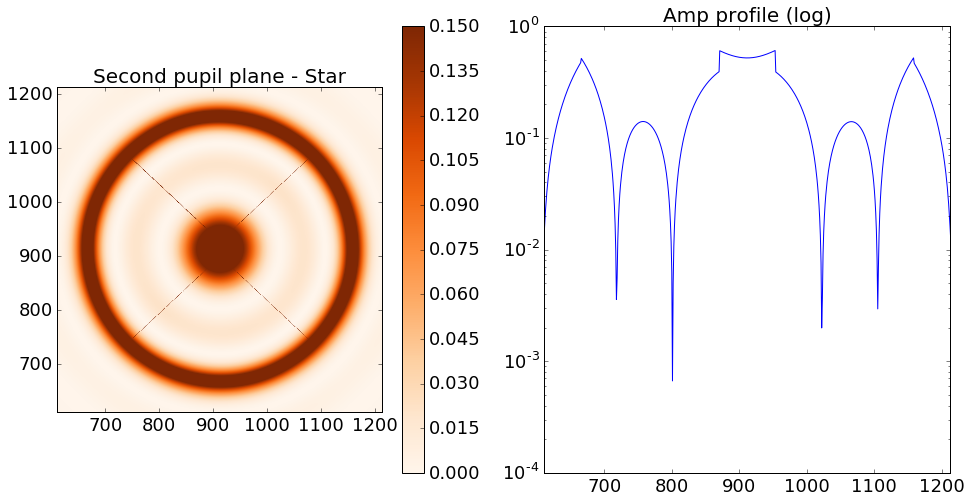

In [80]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(abs(Str_2pup_ef)**2,origin='lower',cmap='Oranges')#,norm=LogNorm())
plt.title('Second pupil plane - Star'); plt.clim(0,0.15)
plt.xlim(611,1212); plt.ylim(611,1212); plt.colorbar()

plt.subplot(122); plt.plot(abs(Str_2pup_ef)[int(N_pix/2),:])
plt.xlim(611,1212); plt.title('Amp profile (log)'); plt.yscale('log')

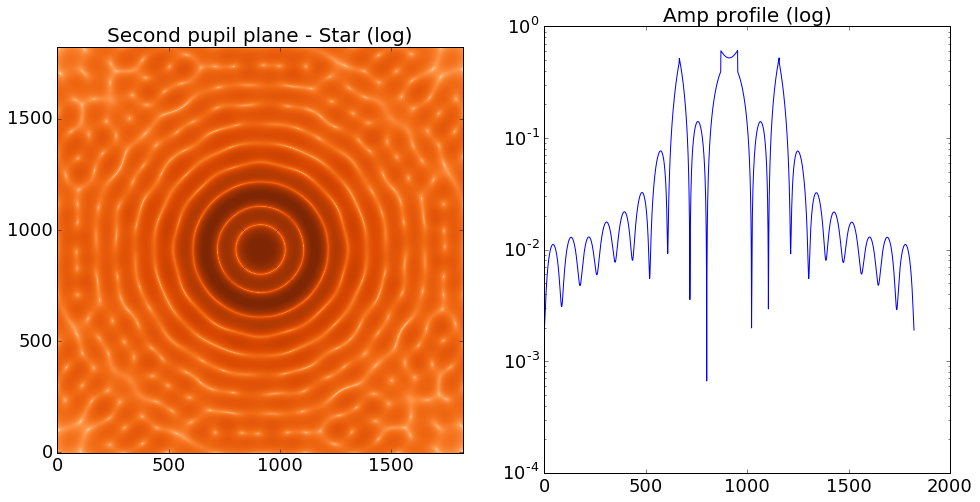

In [81]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(abs(Str_2pup_ef)**2,origin='lower',cmap='Oranges',norm=LogNorm())
plt.title('Second pupil plane - Star (log)'); plt.clim(1e-10,0.15)

plt.subplot(122); plt.plot(abs(Str_2pup_ef)[int(N_pix/2),:])
plt.title('Amp profile (log)'); plt.yscale('log')

The "outer ring" is clearly seen

#### Lyot

In [82]:
Str_lyo_ef = Str_2pup_ef * lyo_k_p

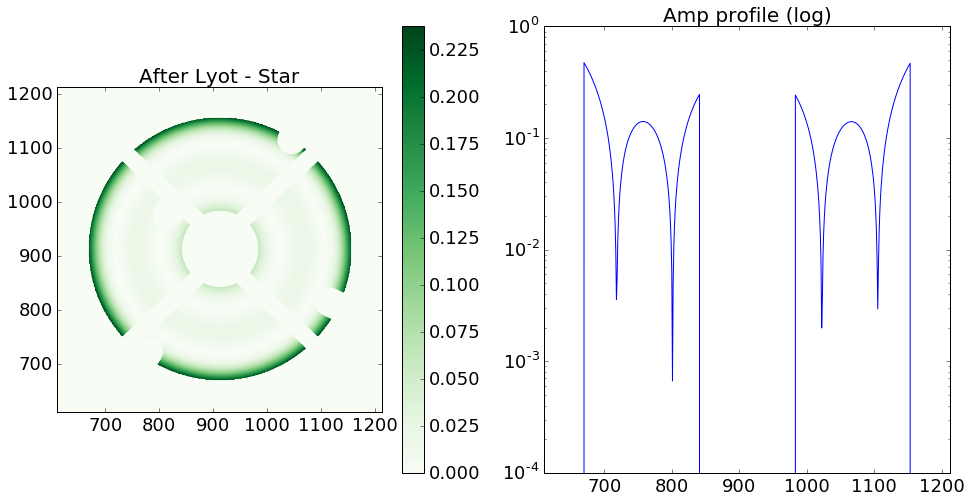

In [84]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(abs(Str_lyo_ef)**2,origin='lower',cmap='Greens')
plt.xlim(611,1212); plt.ylim(611,1212); plt.title('After Lyot - Star')
plt.colorbar(); #plt.clim(0,0.15); 

plt.subplot(122); plt.plot(abs(Str_lyo_ef)[int(N_pix/2),:])
plt.xlim(611,1212); plt.title('Amp profile (log)')
plt.yscale('log')

Lyot stop not blocking the whole ring? Hmmm...

### Final image

In [85]:
%time
Str_final_ef = Ef_aft_from_Ef(Str_lyo_ef)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs


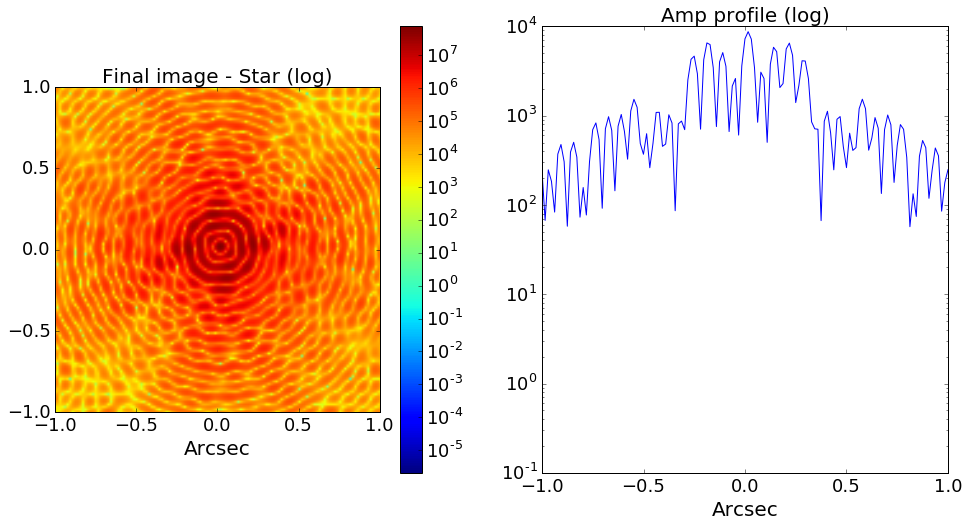

In [86]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(abs(Str_final_ef)**2,origin='lower', \
                             extent=(kx_min,kx_max,ky_min,ky_max),norm=LogNorm())
plt.xlim(-1,1); plt.ylim(-1,1); plt.title('Final image - Star (log)')
plt.xlabel('Arcsec'); plt.colorbar()

plt.subplot(122); plt.plot(np.linspace(kx_min,kx_max,N_pix),abs(Str_final_ef)[int(N_pix/2),:])
plt.xlim(-1,1); plt.title('Amp profile (log)')
plt.xlabel('Arcsec'); plt.yscale('log')